In [66]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite3d_vrel'
run_name = 'nac_easy6a'
data_dir = '../data/'+system_name+'/'+run_name+'/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

## Learning of the 3d kite - relative velocity angle with actor critic

In [43]:
env_params = ut.read_params(data_dir+'param_env.txt')
print(env_params)

{'int_steps': '0.001', 'ep_length': '100', 'decision_time': '1', 'init_theta': '0.7853981633974483', 'init_dtheta': '0', 'init_phi': '0', 'init_dphi': '0', 'alphas': '8,12,14,16,18,20,', 'CL_alphas': '0.75,0.9,1.0,1.08,1.1,1.05,', 'CD_alphas': '0.07,0.1,0.13,0.18,0.18,0.21,', 'init_alpha': '5', 'banks': '-0.06981317007977318,-0.03490658503988659,-0.017453292519943295,0.0,0.017453292519943295,0.03490658503988659,0.06981317007977318,', 'init_bank': '3', 'beta_bins': '-3.141592653589793,-3.08,-3.0,-2.9,-2.7,-2.4,-2.1,-1.8,-1.5,-1.2,-0.9,-0.6,-0.3,0.0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,2.9,3.0,3.08,3.141592653589793,', 'wind_type': 'const', 'v_wind_x': '20', 'v_wind_y': '0', 'v_wind_z': '0'}


In [67]:
# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.001 # sec
env_params['ep_length'] = 100 # sec
env_params['decision_time'] = 1 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
env_params['init_phi'] = 0 # rad
env_params['init_dphi'] = 0 # rad
# attack angles
env_params['alphas'] = [8, 12, 14, 16, 18, 20]
env_params['CL_alphas'] = [0.75, 0.9, 1.0, 1.08, 1.1, 1.05]
env_params['CD_alphas'] = [0.07, 0.1, 0.13, 0.18, 0.18, 0.21]
env_params['init_alpha'] = len(env_params['alphas'])-1 # index, if larger than len it's random
# bank angles
env_params['banks'] = np.deg2rad([-4,-2,-1,0,1,2,4])
env_params['init_bank'] = int(len(env_params['banks'])/2) # index
# angle of relative velocity (bins)
env_params['beta_bins'] = [-np.pi, -3.08, -3.0, -2.9, -2.7, -2.4, -2.1, -1.8, -1.5,-1.2, -0.9, -0.6, -0.3, 0., \
                           0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 2.9, 3.0, 3.08, np.pi]
# wind
env_params['wind_type'] = 'const'
env_params['v_wind_x'] = 20 # m/sec
env_params['v_wind_y'] = 0 # m/sec
env_params['v_wind_z'] = 0 # m/sec

# ALG PARAMETERS
alg_params = dict()
alg_params['alg_type'] = 'nac' # 'ac' for actor-critic, 'nac' for natural actor-critic
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 10000000
print('Dynamical steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Dynamical time, in seconds: ', alg_params['n_steps']*env_params['decision_time'])
alg_params['traj_points'] = 1000

alg_params['init_val_path'] = '../data/'+system_name+'/nac_easy6/' + 'best_value.txt' # Value prior, comment for constant values
alg_params['init_pol_path'] = '../data/'+system_name+'/nac_easy6/' + 'best_policy.txt' # Policy prior, comment for flat policy
alg_params['init_values'] = 0

# Actor learning rate
alg_params['a0'] = 0.00002
alg_params['ac'] = 2000
alg_params['a_expn'] = 1
alg_params['a_burn'] = alg_params['n_steps']
# Critic learning rate
alg_params['b0'] = 0.0000005
alg_params['bc'] = 1000000
alg_params['b_expn'] = 1
alg_params['b_burn'] = alg_params['n_steps']

Dynamical steps:  10000000000.0
Dynamical time, in seconds:  10000000


In [68]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir, 'param_env.txt')
ut.write_params(alg_params, data_dir, 'param_alg.txt')

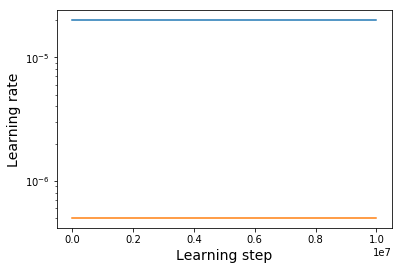

In [70]:
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Learning rate', fontsize=14)
plt.yscale('log')
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
crit_lr = [ut.p_law_burn(x, alg_params['a_burn'], alg_params['a_expn'], alg_params['a0'], alg_params['ac']) for x in xs]
act_lr = [ut.p_law_burn(x, alg_params['b_burn'], alg_params['b_expn'], alg_params['b0'], alg_params['bc']) for x in xs]

plt.plot(xs, crit_lr)
plt.plot(xs, act_lr)

plt.savefig(plot_dir+'lr.png', dpi=200)

In [71]:
import numpy as np
v_traj, s_labels = ut.read_traj(data_dir + 'value_traj.txt')
r_traj, head = ut.read_traj(data_dir + 'return_traj.txt')

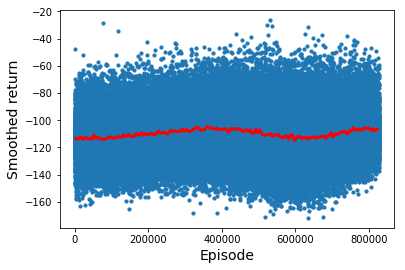

In [72]:
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Smoothed return', fontsize=14)
x, y = ut.smooth_traj(r_traj[:,0], 10)
plt.scatter(x,y,s=10)
x, y = ut.smooth_traj(r_traj[:,0], 5000)
plt.plot(x,y, color='red', lw=3)

plt.savefig(plot_dir+'return.png', dpi=200)

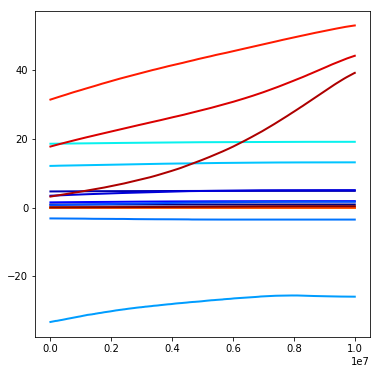

In [73]:
n_alphas=len(env_params['alphas'])
n_banks=len(env_params['banks'])
n_betas=len(env_params['beta_bins'])-1
alpha = n_alphas-1
banks = [int(n_banks/2)]
betas = np.arange(n_betas)

colors = plt.cm.jet(np.linspace(0,1,len(banks)*len(betas)))
plt.figure(figsize=(6,6))
count=0

for p in banks:
    for b in betas:
        index = b+n_betas*(p+n_banks*alpha)
        plt.plot(xs, v_traj[:,index], lw=2, label=s_labels[index], c=colors[count])
        count+=1
    
#plt.legend(loc=0)
plt.savefig(plot_dir+'value_a='+str(alpha)+'.png', dpi=200)

In [74]:
p_traj, s_labels, a_labels = ut.read_2d_traj(data_dir + '/' + "policy_traj.txt")

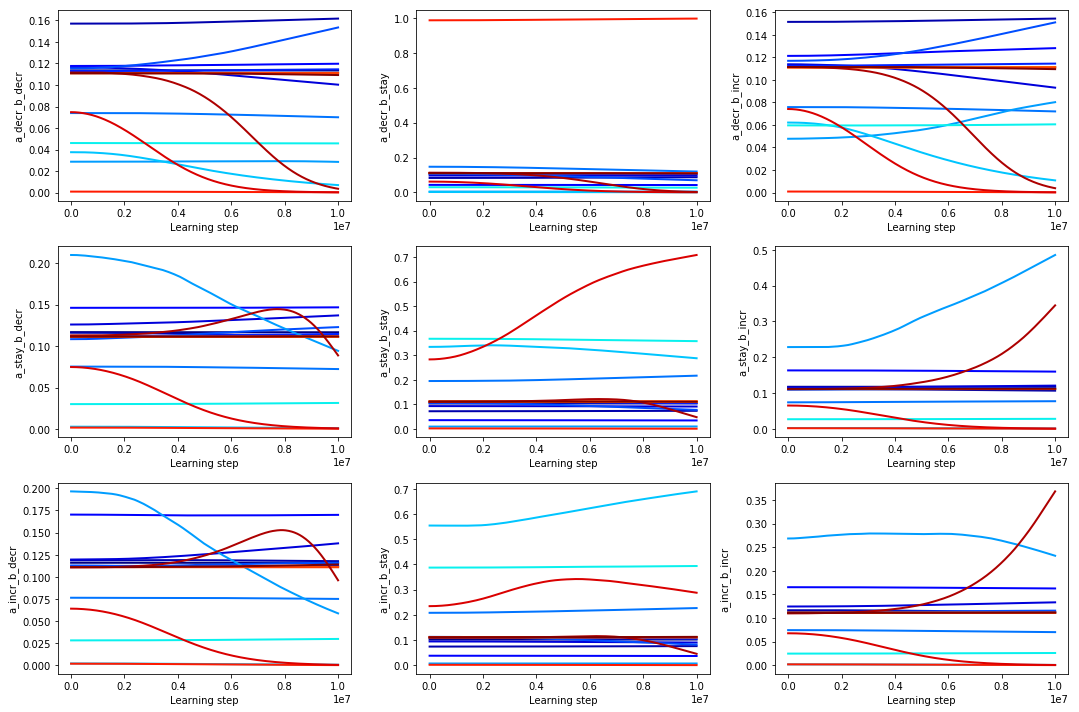

In [75]:
fig, axs = plt.subplots(3,3, figsize=(15,10))
colors = plt.cm.jet(np.linspace(0,1,len(betas)*len(banks)))
states = range(0,len(p_traj[0]))
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )

for a_ind in range(3):
    for b_ind in range(3):
        pl_ind = b_ind + 3*a_ind
        axs[a_ind][b_ind].set_xlabel('Learning step')
        axs[a_ind][b_ind].set_ylabel(a_labels[pl_ind])
        #ax1.set_xlim([0,alg_params['n_steps']])
        #ax1.set_ylim([-100,alg_params['init_values']])
        count=0
        for p in banks:
            for b in betas:
                index = b+n_betas*(p+n_banks*alpha)
                axs[a_ind][b_ind].plot(xs, p_traj[:,index,pl_ind], c=colors[count], lw=2)
                count += 1
                
plt.tight_layout()
plt.savefig(plot_dir+'policy_a='+str(alpha)+'.png', dpi=200)